<a id="table"></a>
Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)


<a id="1"></a>
Notebook Versions</h1>

- Version 1 (10/02/2023)
    * EDA 
    * Baseline modeling 1.0
            
            
- Version 2 (10/03/2023)
    * Baseline modeling 1.0 updated (hill climbing added)
    
    
- Version 3 (10/04/2023)
    * EDA updated
    
    
- Version 4 (10/08/2023)
    * EDA updated
    

- Version 5 (10/08/2023)
    * Fixing bug
    

- Version 6 (10/10/2023)
    * EDA updated
    

- Version 7 (10/11/2023)
    * Baseline modeling 2.0 added
    
    
- Version 8 (10/11/2023)
    * Fixing bug
        
        
- Version 9 (10/11/2023)
    * Updating baseline modeling 2.0
    
    
- Version 10 (10/11/2023)
    * Fixing bug
    
<a id="2"></a>
Loading Libraries</h1>    

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE
%pip install optuna
import optuna


  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/69/60/87a06ef66b34cbe2f2eb0ab66f003664404a7f40c21403a69fad7e28a82b/optuna-3.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/a2/8b/46919127496036c8e990b2b236454a0d8655fd46e1df2fd35610a9cbc842/alembic-1.12.0-py3-none-any.whl.metadata
  Obtaining dependency information for cmaes>=0.10.0 from https://files.pythonhosted.org/packages/f7/46/7d9544d453346f6c0c405916c95fdb653491ea2e9976cabb810ba2fe8cd4/cmaes-0.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.3.0 from https://files.pythonhosted.org/packages/04/88/39f1f5570eb1d28704b4954c97ee91c3b5604f2949ab8ed40b33c90aaad9/SQLAlchemy-2.0.22-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/78.7 kB ? eta -:--:--
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00
  Obtaining dependency i

<a id="3"></a>
Reading Data Files</h1> 

In [ ]:
train = pd.read_csv('/Users/ibeub/Desktop/data/train.csv')
test = pd.read_csv('/Users/ibeub/Desktop/data/test.csv')
submission = pd.read_csv('/Users/ibeub/Desktop/data/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (101763, 23)
The dimension of the test dataset is: (67842, 22)


In [ ]:
train.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,0.179164,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,0.421844,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,0.030000,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,0.080000,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,0.190000,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,26.950000,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [ ]:
test.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,6.784200e+04,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000,67842.000000
mean,135683.500000,37.855945,5.559462,2.857699,3.535715,98.222178,548.422497,0.111521,13.762472,27.635377,2.216432e+04,0.182075,1218.682009,23.131924,1.832493,4.020739,0.200834,11.909776,15.678370,58.325212,39.845258,9.985923
std,19584.442818,55.793918,8.237389,4.666370,5.339085,179.123492,1318.416828,0.100840,14.487425,23.420521,2.072770e+05,0.418493,10739.081373,39.606659,6.229052,7.136069,1.044581,6.974254,17.979368,105.491447,72.756320,15.342975
min,101763.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,118723.250000,13.000000,2.000000,1.000000,1.000000,25.000000,96.210000,0.040000,5.500000,15.540000,5.629400e+02,0.030000,31.270000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,135683.500000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.230000,2.276780e+03,0.080000,126.490000,14.000000,0.000000,2.000000,0.000000,12.000000,12.000000,30.000000,20.000000,5.000000
75%,152643.750000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.140000,18.000000,34.270000,1.011243e+04,0.190000,561.802500,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,44.000000,11.000000
max,169604.000000,1891.000000,470.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,18.380000,935923.390000,1599.000000,344.000000,447.000000,42.000000,411.000000,1026.000000,3368.000000,2301.000000,826.000000


There are not missing values neither in the `train` nor `test` datasets. Since this is synthetic dataset, as a sanity check, we will check for duplicates. First, let's take a look at the `train` dataset.

In [ ]:
print(f"If we remove id from the train dataset the dimension is {train.drop(columns = ['id'], axis = 1).drop_duplicates().shape}")
print(f"If we remove id and defects from the train dataset the dimension is {train.drop(columns = ['id', 'defects'], axis = 1).drop_duplicates().shape}")
print(f"If we remove id, branchCount, and defects from the train dataset the dimension is {train.drop(columns = ['id', 'branchCount', 'defects'], axis = 1).drop_duplicates().shape}")

If we remove id from the train dataset the dimension is (101763, 22)
If we remove id and defects from the train dataset the dimension is (101763, 21)
If we remove id, branchCount, and defects from the train dataset the dimension is (101685, 20)


From the above, we see thera are 78 quasi-duplicated observations in the `train` dataset. Now, let's take a look at the `test` dataset.

In [ ]:
print(f"If we remove id from the test dataset the dimension is {test.drop(columns = ['id'], axis = 1).drop_duplicates().shape}")
print(f"If we remove id and branchCount from the test dataset the dimension is {test.drop(columns = ['id', 'branchCount'], axis = 1).drop_duplicates().shape}")

If we remove id from the test dataset the dimension is (67842, 21)
If we remove id and branchCount from the test dataset the dimension is (67804, 20)


From the above, we see that there are 38 quasi-duplicated observations in the `test` dataset. Finally, let's check if there are observations that appear in both the `train` and `test` datasets.

In [ ]:
to_check = pd.merge(train.drop(columns = ['id', 'defects'], axis = 1), test.drop(columns = 'id', axis = 1))
print(f"There are {to_check.shape[0]} duplicated observations in the train and test datasets")

to_check = pd.merge(train.drop(columns = ['id', 'branchCount', 'defects'], axis = 1), test.drop(columns = ['id', 'branchCount'], axis = 1), on = test.drop(columns = ['id', 'branchCount'], axis = 1).columns.tolist())
print(f"There are {to_check.drop_duplicates().shape[0]} quasi-duplicated observations in the train and test datasets")

There are 0 duplicated observations in the train and test datasets
There are 116 quasi-duplicated observations in the train and test datasets


<a id="4"></a>
Data Exploration</h1>

First, we start by visualizing `defects`, the variable of interest.

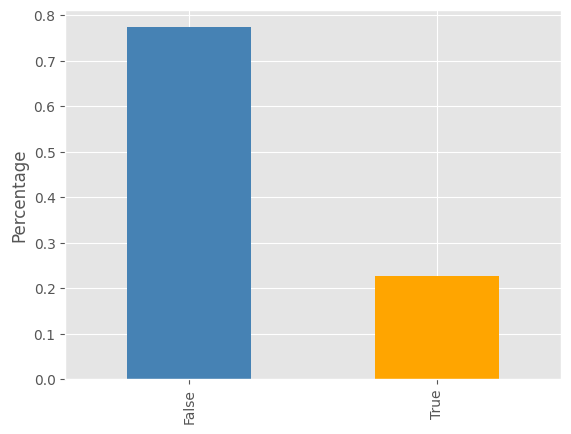

In [ ]:
train['defects'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange'])
plt.ylabel('Percentage');

From the above barplot, we see the data is imbalanced (~77% False and ~23% True). Next, we proceed to explore potential correlations among the input features.

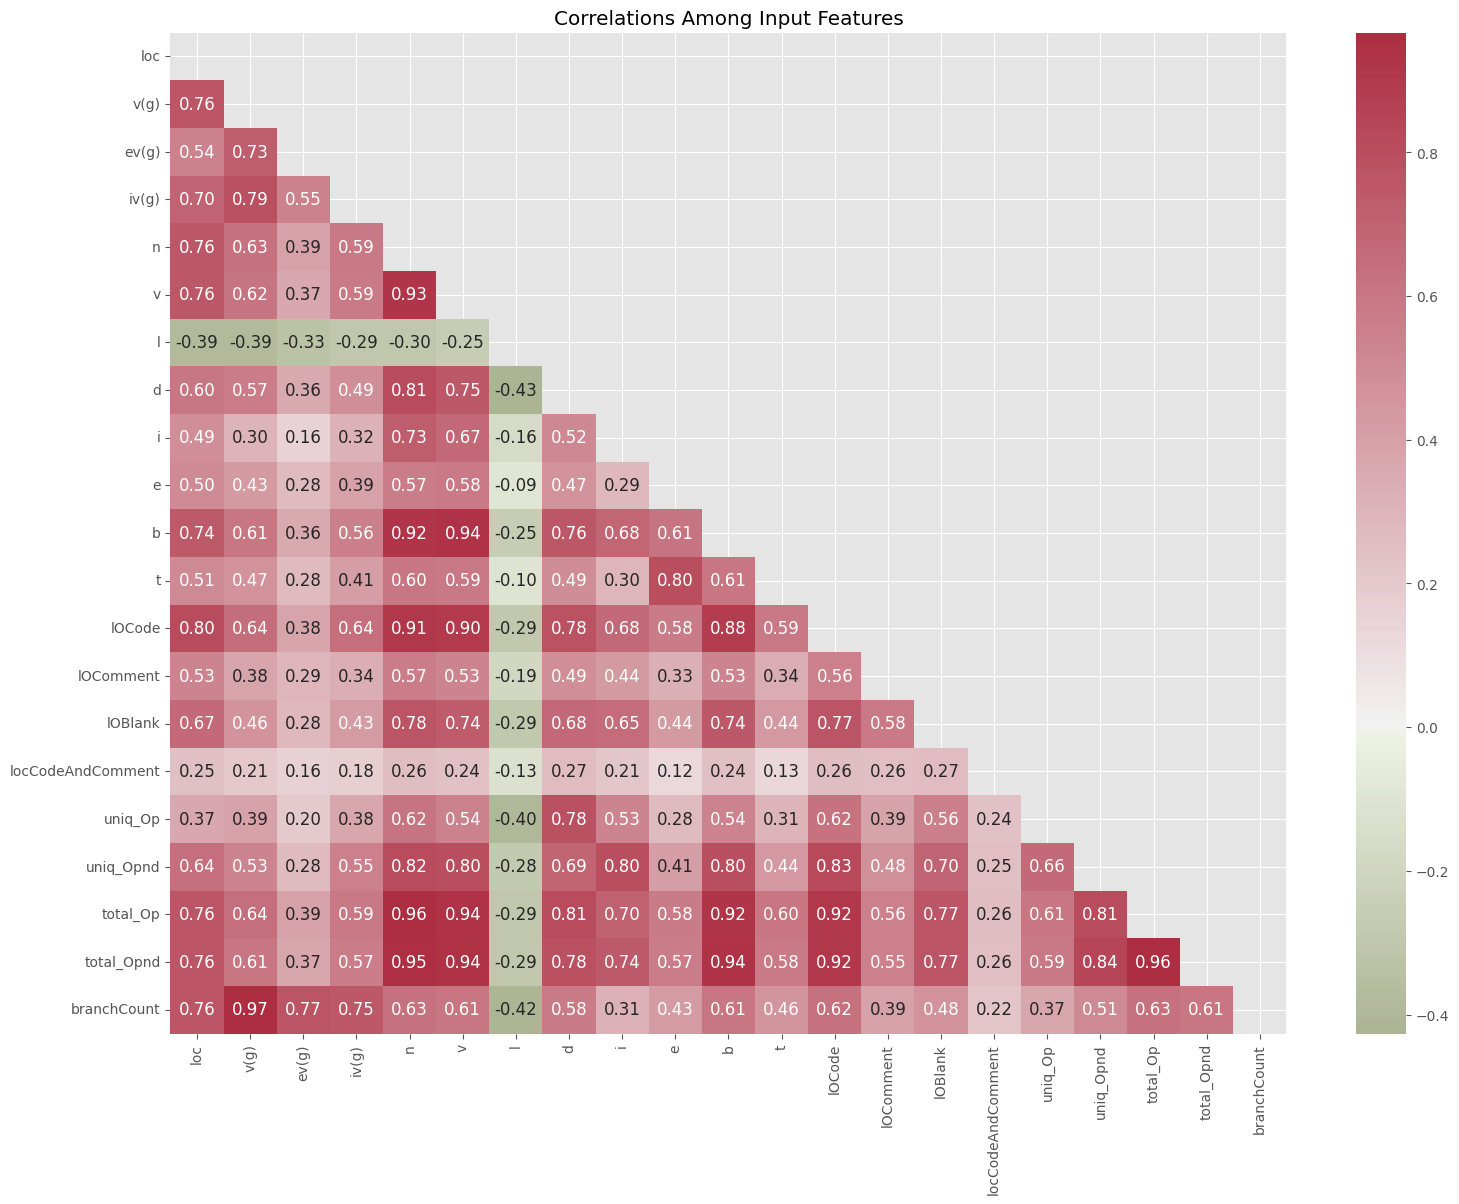

In [ ]:
corr_mat = train.drop(columns = ['id', 'defects'], axis = 1).corr()

data_mask = np.triu(np.ones_like(corr_mat, dtype = bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Input Features');


From the above, these are couple of observations:

- There is a 97% correlation between `branchCount` and `v(g)`.
- There is a 96% correlation between `total_Opnd` and `total_Op`
- There is a 96% correlation between `total_Op` and `n`
- `l` is the only feature that is negative correlated with the other features.

Based on the above correlation heatmap, we proceed to explore the idea of dimension reduction via `PCA`. Notice the the all the input features are right-skewed, so before we run `PCA` we `log-transform` the features before `PCA` is applied.

In [ ]:
colnames = train.drop(columns = ['id', 'defects'], axis = 1).columns.tolist()

pca_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA())]).fit(train[colnames])

pca_md

Pipeline(steps=[('log-tran',
                 ColumnTransformer(transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['loc', 'v(g)', 'ev(g)',
                                                   'iv(g)', 'n', 'v', 'l', 'd',
                                                   'i', 'e', 'b', 't', 'lOCode',
                                                   'lOComment', 'lOBlank',
                                                   'locCodeAndComment',
                                                   'uniq_Op', 'uniq_Opnd',
                                                   'total_Op', 'total_Opnd',
                                                   'branchCount'])])),
                ('stand', StandardScaler()), ('pca', PCA())])

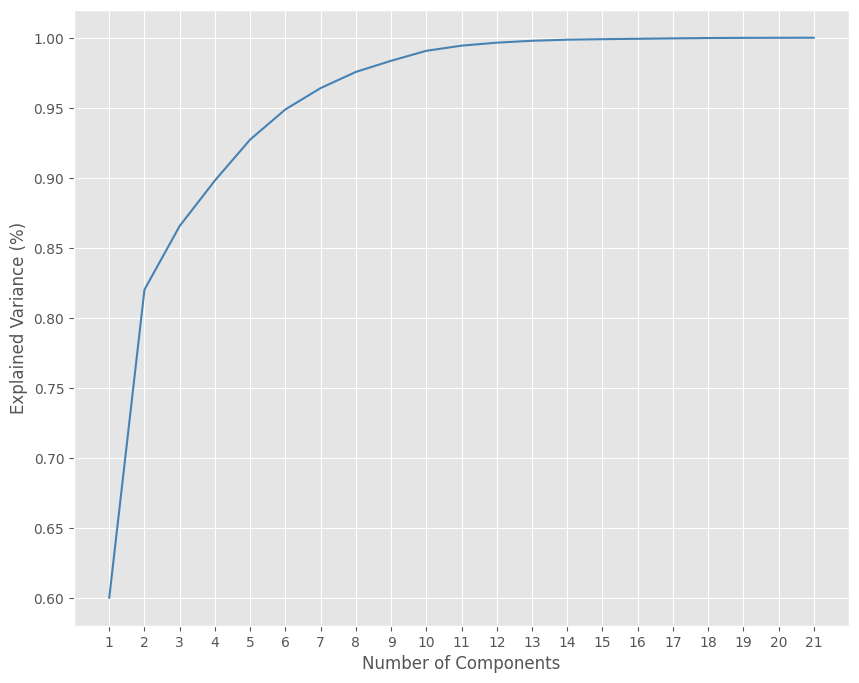

In [ ]:
plt.figure(figsize = (10, 8))
ax = sns.lineplot(x = [i for i in range(1, 22)], y = np.cumsum(pca_md['pca'].explained_variance_ratio_), color = 'steelblue', markers = True);
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance (%)')
ax.set_xticks([i for i in range(1, 22)]);

From the above, we see that the first 10 components explain more than 99% of the variability in the data. Next let's visualize the the components to see if there is a pattern to be exploit.

In [21]:
pca_10 = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA(n_components = 10))]).fit_transform(train[colnames])

pca_10 = pd.DataFrame(pca_10, columns = [str('PCA_') + str(i) for i in range(1, 11)])
pca_10['defects'] = train['defects'].map({False: 0, True: 1})

sns.pairplot(data = pca_10, hue = 'defects', corner = True);

c:\Python39\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


From the above `PCA` pair-plots, these are some observations:

- The two classes are not linearly separable.
- There are some samples (`defects = True`) that are difficult to predict. For instance, if we take a close look at `PCA_1` and `PCA_2` plot, in the bottom left corner, there are some blue samples (`defects = True`) when the majority of samples in that area are red (`defects = False`).

Next, we run `k-means` to see if there is an interesting pattern to be exploited.


In [ ]:
inertias = list()

for i in tqdm(range(2, 21)):

    kmeans_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                          ('stand', StandardScaler()), 
                          ('kmeans', KMeans(n_clusters = i, n_init = 20, random_state = 42))]).fit(train[colnames])

    inertias.append(kmeans_md['kmeans'].inertia_)
    
sns.lineplot(x = [i for i in range(2, 21)], y = inertias, color = 'steelblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Inertia');

From the above, plot, based on the cluster intertia, it seems that 5 clusters is the appropriate number of clusters for this dataset (based on the elbow approach). Next, we explore the proportion of `defects` in each of the clusters.

In [ ]:
kmeans = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('kmeans', KMeans(n_clusters = 5, n_init = 20, random_state = 42))]).fit(train[colnames])

train['cluster'] = kmeans['kmeans'].labels_

print('The proportion of defects in each of the clusters is \n')
print(train.groupby('cluster')['defects'].mean())

From the above, these are a couple of observations:

- Cluster 4 is the cluster with higher number of `defects`.
- Cluster 2 is the second cluster with the highest number of `defects`.
- Cluster 0 is the cluster with the least number of `defects`.

Next, we briefly explore a couple of bivariate relationships as shown below.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))

sns.scatterplot(ax = axes[0], data = train, x = 'uniq_Op', y = 'uniq_Opnd', hue = 'defects');
sns.scatterplot(ax = axes[1], data = train, x = 'total_Op', y = 'total_Opnd', hue = 'defects');

From the above plots, these are a couple of observations:

- There are several outliers in this data. 
- There is not a clear pattern that can be leveraged to separate the two classes.

Next, we count the number of unique values in each of the input features as follows.

In [ ]:
train.drop(columns = ['id', 'defects'], axis = 1).nunique()

From the above, notice that `locCodeAndComment` is the feature with the least number of unique values; it has only 29 unique values. 

<a id="5"></a>
Baseline Modeling 1.0</h1>

First, we start by building some standard models without feature engineering nor HPO. First, we define the input and target features.

In [ ]:
X = train.drop(columns = ['id', 'defects', 'cluster'], axis = 1)
Y = train['defects'].map({False: 0, True: 1})

test_cv = test.drop(columns = ['id'], axis = 1)

First, we define the hill ensemble function to ensemble model predictions.

In [ ]:
def hill_climbing(x, y, x_test):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2]

Next, we build a few standard models in a 10-fold cross-validation routine.

In [ ]:
ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds =  list(), list()

sk = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    ########
    ## RF ##
    ########

    RF_md = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)
    
    RF_pred = RF_md.predict_proba(X_test)[:, 1]
    RF_score = roc_auc_score(Y_test, RF_pred)

    print('Fold', i, '==> RF oof ROC-AUC score is ==>', RF_score)

    RF_pred_test = RF_md.predict_proba(test_cv)[:, 1]
    
    #################
    ## Extra Trees ##
    #################

    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10).fit(X_train, Y_train)

    ET_pred = ET_md.predict_proba(X_test)[:, 1]
    ET_score = roc_auc_score(Y_test, ET_pred)

    print('Fold', i, '==> ET oof ROC-AUC score is ==>', ET_score)

    ET_pred_test = ET_md.predict_proba(test_cv)[:, 1]

    ##########################
    ## HistGradientBoosting ##
    ##########################

    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 500,
                                             max_depth = 5,
                                             max_bins = 255,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 10).fit(X_train, Y_train)
    
    hist_pred = hist_md.predict_proba(X_test)[:, 1]
    hist_score = roc_auc_score(Y_test, hist_pred)

    print('Fold', i, '==> Hist oof ROC-AUC score is ==>', hist_score)  

    hist_pred_test = hist_md.predict_proba(test_cv)[:, 1]

    ##########
    ## LGBM ##
    ##########

    LGBM_md = LGBMClassifier(objective = 'binary',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_score = roc_auc_score(Y_test, lgb_pred)

    print('Fold', i, '==> LGBM oof ROC-AUC score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict_proba(test_cv)[:, 1]

    #########
    ## XGB ##
    #########

    XGB_md = XGBClassifier(objective = 'binary:logistic',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    xgb_pred = XGB_md.predict_proba(X_test)[:, 1]
    xgb_score = roc_auc_score(Y_test, xgb_pred)

    print('Fold', i, '==> XGB oof ROC-AUC score is ==>', xgb_score)

    xgb_pred_test = XGB_md.predict_proba(test_cv)[:, 1]

    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostClassifier(loss_function = 'Logloss',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict_proba(X_test)[:, 1]
    cat_score = roc_auc_score(Y_test, cat_pred)

    print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)

    cat_pred_test = Cat_md.predict_proba(test_cv)[:, 1]    
    
    ##############
    ## Ensemble ##
    ##############
    
    ens_pred_1 = (RF_pred + ET_pred + hist_pred + lgb_pred + xgb_pred + cat_pred) / 6
    ens_pred_2 = (RF_pred_test + ET_pred_test + hist_pred_test + lgb_pred_test + xgb_pred_test + cat_pred_test) / 6
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ############################
    ## Hill Climbing Ensemble ##
    ############################
    
    x = pd.DataFrame({'RF': RF_pred,
                      'ET': ET_pred, 
                      'Hist': hist_pred, 
                      'LGBM': lgb_pred,
                      'XGB': xgb_pred,
                      'Cat': cat_pred})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': RF_pred_test,
                           'ET': ET_pred_test, 
                           'Hist': hist_pred_test, 
                           'LGBM': lgb_pred_test,
                           'XGB': xgb_pred_test,
                           'Cat': cat_pred_test})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

In [ ]:
print('The average ensemble oof ROC-AUC score over the 10-folds is', np.mean(ens_cv_scores))
print('The hill climbing ensemble oof ROC-AUC score over the 10-folds is', np.mean(hill_ens_cv_scores))

In [ ]:
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('Avereage_Ensemble_Baseline_submission.csv', index = False)

ens_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('Hill_Ensemble_Baseline_submission.csv', index = False)

<a id="6"></a>
Baseline Modeling 2.0</h1>

In this section, we run a computational intensive experiment. Basically, we will increase the number of folds and see if that helps to improve model performance. Basically, we re-run baseline modeling 1.0 five times with increasing number of folds. However, in this case, we `log1p` transform all of the input features before we train the models.

In [ ]:
X = train.drop(columns = ['id', 'defects', 'cluster'], axis = 1)
X = X.apply(lambda x: np.log1p(x))
Y = train['defects'].map({False: 0, True: 1})

test_cv = test.drop(columns = ['id'], axis = 1)
test_cv = test_cv.apply(lambda x: np.log1p(x))

In [ ]:
ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds =  list(), list()

sk = RepeatedStratifiedKFold(n_splits = 25, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    ########
    ## RF ##
    ########

    RF_md = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)
    
    RF_pred = RF_md.predict_proba(X_test)[:, 1]
    RF_score = roc_auc_score(Y_test, RF_pred)

    print('Fold', i, '==> RF oof ROC-AUC score is ==>', RF_score)

    RF_pred_test = RF_md.predict_proba(test_cv)[:, 1]
    
    #################
    ## Extra Trees ##
    #################

    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10).fit(X_train, Y_train)

    ET_pred = ET_md.predict_proba(X_test)[:, 1]
    ET_score = roc_auc_score(Y_test, ET_pred)

    print('Fold', i, '==> ET oof ROC-AUC score is ==>', ET_score)

    ET_pred_test = ET_md.predict_proba(test_cv)[:, 1]

    ##########################
    ## HistGradientBoosting ##
    ##########################

    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 500,
                                             max_depth = 5,
                                             max_bins = 255,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 10).fit(X_train, Y_train)
    
    hist_pred = hist_md.predict_proba(X_test)[:, 1]
    hist_score = roc_auc_score(Y_test, hist_pred)

    print('Fold', i, '==> Hist oof ROC-AUC score is ==>', hist_score)  

    hist_pred_test = hist_md.predict_proba(test_cv)[:, 1]

    ##########
    ## LGBM ##
    ##########

    LGBM_md = LGBMClassifier(objective = 'binary',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_score = roc_auc_score(Y_test, lgb_pred)

    print('Fold', i, '==> LGBM oof ROC-AUC score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict_proba(test_cv)[:, 1]

    #########
    ## XGB ##
    #########

    XGB_md = XGBClassifier(objective = 'binary:logistic',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    xgb_pred = XGB_md.predict_proba(X_test)[:, 1]
    xgb_score = roc_auc_score(Y_test, xgb_pred)

    print('Fold', i, '==> XGB oof ROC-AUC score is ==>', xgb_score)

    xgb_pred_test = XGB_md.predict_proba(test_cv)[:, 1]

    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostClassifier(loss_function = 'Logloss',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict_proba(X_test)[:, 1]
    cat_score = roc_auc_score(Y_test, cat_pred)

    print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)

    cat_pred_test = Cat_md.predict_proba(test_cv)[:, 1]    
    
    ##############
    ## Ensemble ##
    ##############
    
    ens_pred_1 = (RF_pred + ET_pred + hist_pred + lgb_pred + xgb_pred + cat_pred) / 6
    ens_pred_2 = (RF_pred_test + ET_pred_test + hist_pred_test + lgb_pred_test + xgb_pred_test + cat_pred_test) / 6
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ############################
    ## Hill Climbing Ensemble ##
    ############################
    
    x = pd.DataFrame({'RF': RF_pred,
                      'ET': ET_pred, 
                      'Hist': hist_pred, 
                      'LGBM': lgb_pred,
                      'XGB': xgb_pred,
                      'Cat': cat_pred})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': RF_pred_test,
                           'ET': ET_pred_test, 
                           'Hist': hist_pred_test, 
                           'LGBM': lgb_pred_test,
                           'XGB': xgb_pred_test,
                           'Cat': cat_pred_test})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

In [ ]:
print('The average ensemble oof ROC-AUC score over the 25-folds is', np.mean(ens_cv_scores))
print('The hill climbing ensemble oof ROC-AUC score over the 25-folds is', np.mean(hill_ens_cv_scores))

In [ ]:
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('Avereage_Ensemble_Baseline_submission_25_folds.csv', index = False)

ens_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('Hill_Ensemble_Baseline_submission_25_folds.csv', index = False)